In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.table import Table, Column
from itertools import combinations
from sklearn import linear_model
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from edge_pydb import EdgeTable
from edge_pydb.conversion import msd_co
from edge_pydb.plotting import xy2hist, xy2binned, gridplot
from adjustText import adjust_text
from scipy import stats, odr
np.seterr(invalid='ignore')
plt.rcParams["scatter.edgecolors"] = 'none'

# Spatially resolved SF relations for EDGE
## Here we use the matched 7" resolution database (surface densities not deprojected)
### For CO, we use the 'dil' mask, which differs in velocity width from the 'str' mask.  For non-detections we scale the 'str' noise down to the median velocity width for the 'dil' mask.
### For SFR, we load the extinction uncorrected values, as well as the pixel-wise Balmer decrement corrected values, and the "adopted" values where the extinction is calculated after smoothing the H$\alpha$ and H$\beta$ images.  The adopted values are used in most plots.
### Detections must be >3$\sigma$ in both CO and H$\alpha$ with a valid extinction-corrected SFR measurement.

In [2]:
# limit the columns we read to avoid information overload
sspcols   = ['Name','ix','iy','mass_ssp_sm','sigstar_sm']
fluxcols  = ['Name','ix','iy',
             'flux_Halpha_sm','flux_Hbeta_sm','e_flux_Halpha_sm','e_flux_Hbeta_sm',
             'flux_Halpha_sm3_sm','flux_Hbeta_sm3_sm',
             'flux_sigsfr0_sm','e_flux_sigsfr0_sm',
             'flux_sigsfr_corr_sm','e_flux_sigsfr_corr_sm','flux_AHa_corr_sm',
             'flux_sigsfr_adopt_sm','flux_AHa_smooth3_sm',
             'EW_Halpha_sm','BPT_sm','p_BPT_sm','SF_BPT_sm']
comomcols = ['Name','ix','iy','mom0_12','e_mom0_12','sigmol','e_sigmol']

# Read the tables
globaltab = EdgeTable('edge_califa.csv', cols=['Name','caMstars','caSFR'])
cofluxtab = EdgeTable('edge_coflux_smo7.csv', cols=['Name','coNomaskDv_smo7','coDilatedDv_smo7'])
try: 
    fluxtab = EdgeTable('edge_carma.2d_smo7.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab  = EdgeTable('edge_carma.2d_smo7.hdf5',  path='SSP_sm', cols=sspcols)
    cotab   = EdgeTable('edge_carma.2d_smo7.hdf5',   path='comom_dil', cols=comomcols)
    conomasktab = EdgeTable('edge_carma.2d_smo7.hdf5', path='comom_str', cols=['Name','ix','iy','e_mom0_12'])
    print('Working on full EDGE database')
except:
    fluxtab = EdgeTable('NGC4047.2d_smo7.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab  = EdgeTable('NGC4047.2d_smo7.hdf5', path='SSP_sm', cols=sspcols)
    cotab   = EdgeTable('NGC4047.2d_smo7.hdf5', path='comom_dil', cols=comomcols)
    conomasktab = EdgeTable('NGC4047.2d_smo7.hdf5', path='comom_str', cols=['Name','ix','iy','e_mom0_12'])
    print('Working on NGC 4047 data')

Working on full EDGE database


In [3]:
print('Median unmasked velocity width is',np.nanmedian(cofluxtab['coNomaskDv_smo7']))
print('Median masked velocity width is',np.nanmedian(cofluxtab['coDilatedDv_smo7']))
nsefactor = np.sqrt(np.nanmedian(cofluxtab['coDilatedDv_smo7'])/np.nanmedian(cofluxtab['coNomaskDv_smo7']))
print('Noise estimates will be scaled down by',nsefactor)

Median unmasked velocity width is 860.0
Median masked velocity width is 400.0
Noise estimates will be scaled down by 0.6819943394704735


In [4]:
# consolidate the tables
fluxtab.join(ssptab, keys=['Name', 'ix', 'iy'])
fluxtab.join(cotab, keys=['Name', 'ix', 'iy'])
conomasktab['e_mom0max_12'] = nsefactor * conomasktab['e_mom0_12']
conomasktab.remove_column('e_mom0_12')
fluxtab.join(conomasktab, keys=['Name', 'ix', 'iy'])
fluxtab.join(globaltab)
# Use the error in extinction-corrected SFR for error in adopted SFR
fluxtab['e_flux_sigsfr_adopt_sm'] = fluxtab['e_flux_sigsfr_corr_sm']
fluxtab['t_dep'] = fluxtab['sigmol'].quantity/fluxtab['flux_sigsfr_adopt_sm'].quantity
fluxtab['f_mol'] = fluxtab['sigmol'].quantity/fluxtab['sigstar_sm'].quantity
fluxtab['ssfr'] = fluxtab['flux_sigsfr_adopt_sm'].quantity/fluxtab['sigstar_sm'].quantity
# Global offset from the main sequence
fluxtab['delSFR'] = fluxtab['caSFR'] - (0.81*fluxtab['caMstars']-8.34)
print(fluxtab.colnames)

['Name', 'ix', 'iy', 'flux_Halpha_sm', 'flux_Hbeta_sm', 'e_flux_Halpha_sm', 'e_flux_Hbeta_sm', 'flux_Halpha_sm3_sm', 'flux_Hbeta_sm3_sm', 'flux_sigsfr0_sm', 'e_flux_sigsfr0_sm', 'flux_sigsfr_corr_sm', 'e_flux_sigsfr_corr_sm', 'flux_AHa_corr_sm', 'flux_sigsfr_adopt_sm', 'flux_AHa_smooth3_sm', 'EW_Halpha_sm', 'BPT_sm', 'p_BPT_sm', 'SF_BPT_sm', 'mass_ssp_sm', 'sigstar_sm', 'mom0_12', 'e_mom0_12', 'sigmol', 'e_sigmol', 'e_mom0max_12', 'caMstars', 'caSFR', 'e_flux_sigsfr_adopt_sm', 't_dep', 'f_mol', 'ssfr', 'delSFR']


### The `twodet` array indicates pixels detected in CO and H$\alpha$ and for which the Balmer decrement correction could be applied.

In [5]:
# Apply a 3-sigma cut to CO and Halpha
codet = fluxtab['mom0_12'] > 3*fluxtab['e_mom0_12']
hadet = fluxtab['flux_Halpha_sm'] > 3*fluxtab['e_flux_Halpha_sm']
sfdet = hadet & ~np.isnan(fluxtab['flux_sigsfr_adopt_sm'])
twodet = codet & sfdet
np.count_nonzero(twodet)

7042

### Identify which galaxies contribute the most pixels to the plot.

In [6]:
df = pd.DataFrame(fluxtab['Name'][twodet])
pd.set_option('display.max_rows', 1000)
df2 = df['Name'].value_counts().to_frame()
print(df2)

              count
Name               
NGC2253         190
NGC6060         187
NGC5480         167
NGC4047         143
NGC5908         141
NGC6301         137
NGC6155         132
NGC6361         131
NGC5980         130
NGC6478         128
NGC2906         126
NGC5633         126
NGC5218         122
NGC2639         119
NGC4210         116
NGC5016         114
NGC5614         113
UGC04132        112
NGC3811         112
NGC2347         109
IC4566          104
NGC5406         103
NGC2410         103
NGC6004         102
UGC09476        102
NGC6186          98
NGC0551          98
NGC0477          96
NGC5953          91
NGC0523          89
IC0944           86
UGC05111         82
UGC10123         79
NGC2487          78
NGC4711          78
NGC5056          77
IC1199           75
IC2247           73
NGC5520          72
NGC0496          69
UGC03973         69
UGC08107         68
NGC3994          67
UGC04029         66
UGC09537         66
UGC09665         66
NGC4644          65
IC2487           65


### Identify outliers

[['NGC2639' '7']
 ['ARP220' '3']
 ['NGC1167' '3']
 ['NGC2480' '2']
 ['NGC5614' '2']
 ['NGC0523' '2']
 ['NGC0447' '2']
 ['UGC10043' '2']
 ['NGC3381' '1']
 ['UGC09759' '1']
 ['NGC6060' '1']
 ['NGC6314' '1']
 ['NGC7738' '1']
 ['UGC03973' '1']
 ['UGC05359' '1']
 ['UGC09476' '1']
 ['NGC2410' '1']]


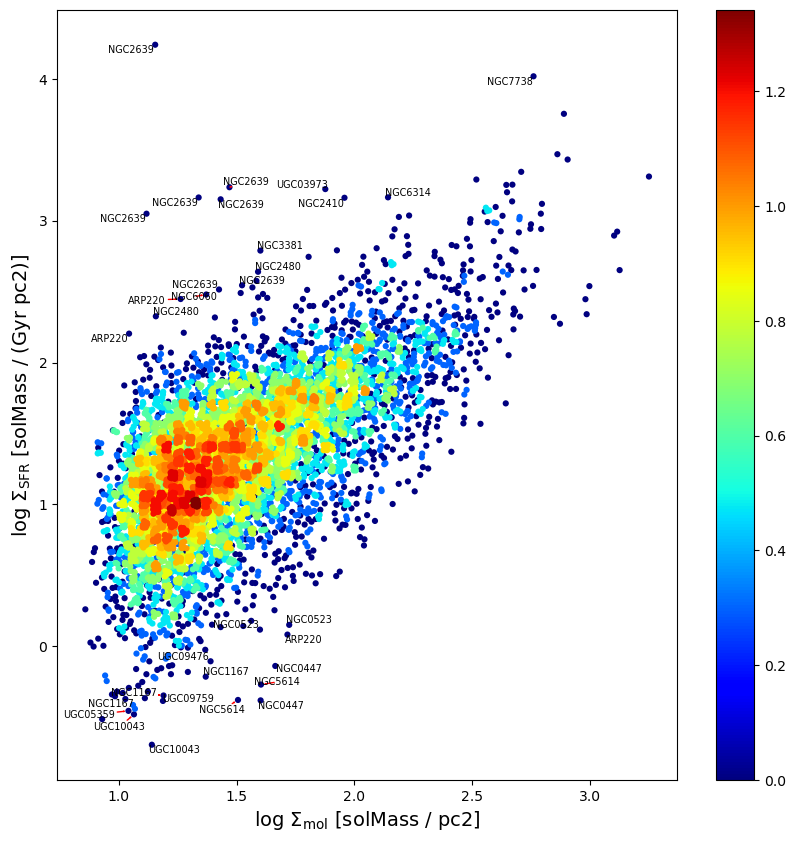

In [7]:
x_det, y_det, z_det, *hist = xy2hist(fluxtab['sigmol'][twodet], 
                                     fluxtab['flux_sigsfr_adopt_sm'][twodet], log=True)
fig, ax = plt.subplots(figsize=(10,10))
sc = ax.scatter(x_det, y_det, c=z_det, s=20, cmap='jet')
plt.xlabel(r'log $\Sigma_{\rm mol}$ ['+str(fluxtab['sigmol'].unit)+']',fontsize=14)
plt.ylabel(r'log $\Sigma_{\rm SFR}$ ['+str(fluxtab['flux_sigsfr_adopt_sm'].unit)+']',fontsize=14)
cb = plt.colorbar(sc)
select = twodet & ((fluxtab['t_dep'] > 30) | (fluxtab['t_dep'] < 0.1))
xpos = np.log10(fluxtab['sigmol'][select])
ypos  = np.log10(fluxtab['flux_sigsfr_adopt_sm'][select])
lbl = fluxtab['Name'][select]
texts = [plt.text(xpos[i], ypos[i], lbl[i], ha='center', va='center',size='x-small')
         for i in range(len(xpos))]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
unique, counts = np.unique(lbl, return_counts=True)
print(np.asarray((unique[(-counts).argsort()], sorted(counts, reverse=True))).T)

### Spatially resolved CO vs. Halpha (both tracers detected)

In [8]:
def model(p, x):
    a, b = p
    return a + b*x

def fitODR(x ,y, xerr=None, yerr=None, verbose=False):
    sorted=np.argsort(x)
    xfit = x[sorted]
    yfit = y[sorted]
    if xerr is not None:
        xerrfit = xerr[sorted]
    else:
        xerrfit = None
    if yerr is not None:
        yerrfit = yerr[sorted]
    else:
        yerrfit = None
    b, a, rval, pval, std_err = stats.linregress(xfit, yfit)
    print("\nLineregress parameters: {:.2f} + x*({:.2f}+/-{:.2f})".format(
           a, b, std_err))
    # --- scipy ODR approach
    linear = odr.Model(model)
    mydata = odr.RealData(x, y, sx=xerr, sy=yerr)
    myodr  = odr.ODR(mydata, linear, beta0=[a,b])
    myoutput = myodr.run()
    if verbose:
        print("\n======== Results from scipy.odr =========")
        myoutput.pprint()
    c, d = myoutput.beta
    c_err, d_err = myoutput.sd_beta
    yscat = np.std(yfit-model([c, d], xfit))
    return c, c_err, d, d_err, yscat


Lineregress parameters: -0.28 + x*(0.58+/-0.01)

Lineregress parameters: -0.28 + x*(0.58+/-0.01)


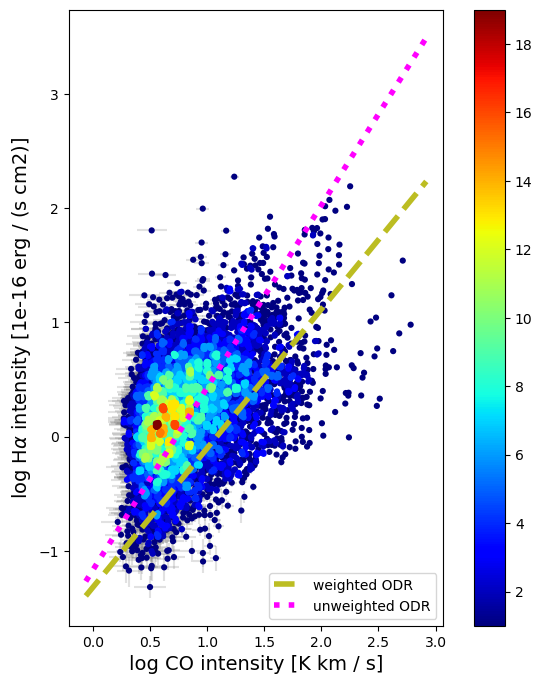

In [9]:
# Make the scatter plot (measured values)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
valid = codet & hadet
x_dat = np.log10(fluxtab['mom0_12'][valid])
y_dat = np.log10(fluxtab['flux_Halpha_sm'][valid])
x_err = (fluxtab['e_mom0_12'][valid]/fluxtab['mom0_12'][valid])/np.log(10)
y_err = (fluxtab['e_flux_Halpha_sm'][valid]/fluxtab['flux_Halpha_sm'][valid])/np.log(10)
ycept0, e_ycept0, slp0, e_slp0, yscat0 = fitODR(x_dat, y_dat, x_err, y_err)
ycept1, e_ycept1, slp1, e_slp1, yscat1 = fitODR(x_dat, y_dat)
x_hist, y_hist, z_hist, *hist = xy2hist(x_dat, y_dat, log=False)
sc = ax.scatter(x_hist, y_hist, c=z_hist, s=20, cmap='jet')
ax.errorbar(x_dat, y_dat, xerr=x_err, yerr=y_err, ecolor='dimgrey',
             ls='None', marker='None', zorder=-1, alpha=0.2)
# Plot the ODR fit
xlims = ax.get_xlim()
xmod = np.linspace(xlims[0],xlims[1],50)
ymod0 = model([ycept0, slp0], xmod)
ax.plot(xmod, ymod0, linestyle='--', linewidth=4, color='tab:olive', zorder=2, label='weighted ODR')
ymod1 = model([ycept1, slp1], xmod)
ax.plot(xmod, ymod1, linestyle=':', linewidth=4, color='magenta', zorder=2, label='unweighted ODR')
plt.xlabel('log CO intensity ['+str(fluxtab['mom0_12'].unit)+']',fontsize=14)
plt.ylabel(r'log H$\alpha$ intensity ['+str(fluxtab['flux_Halpha_sm'].unit)+']',fontsize=14)
cb = plt.colorbar(sc)
ax.legend(loc='lower right')

### Compare extinction corrections for the spatially resolved SF law (unweighted ODR fit to detections in both axes)


Number detected in both axes: 7102
Not detected in sigmol: 24535
Not detected in sigsfr0: 253
Not detected in either: 199235

Lineregress parameters: -0.02 + x*(0.58+/-0.01)

Number detected in both axes: 6926
Not detected in sigmol: 22386
Not detected in sigsfr_corr: 429
Not detected in either: 201384

Lineregress parameters: -0.12 + x*(0.95+/-0.02)

Number detected in both axes: 6913
Not detected in sigmol: 22310
Not detected in sigsfr_adopt: 442
Not detected in either: 201460

Lineregress parameters: -0.11 + x*(0.95+/-0.01)

Number detected in both axes: 4653
Not detected in sigmol: 9901
Not detected in sigsfr0: 0
Not detected in either: 10

Lineregress parameters: 0.12 + x*(0.59+/-0.01)

Number detected in both axes: 4652
Not detected in sigmol: 9897
Not detected in sigsfr_corr: 1
Not detected in either: 14

Lineregress parameters: 0.04 + x*(0.93+/-0.02)

Number detected in both axes: 4652
Not detected in sigmol: 9895
Not detected in sigsfr_adopt: 1
Not detected in either: 16

Lin

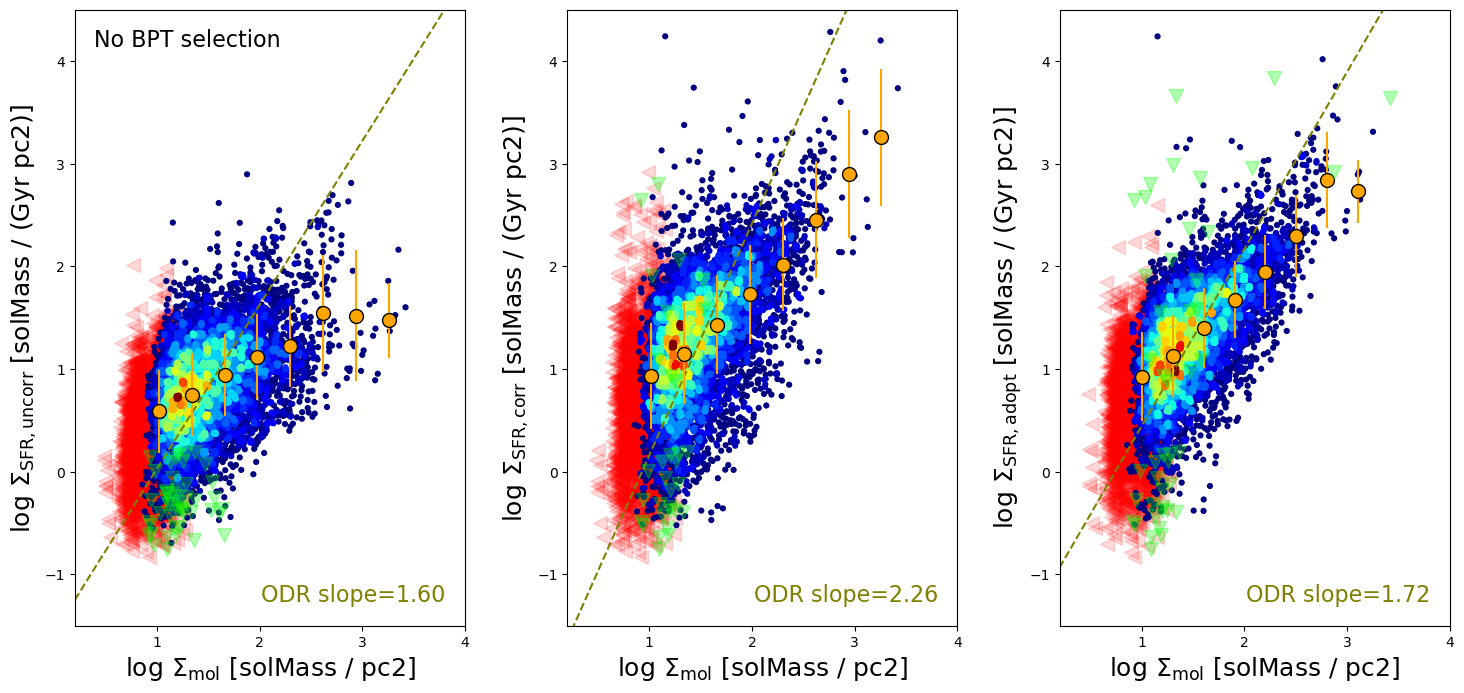

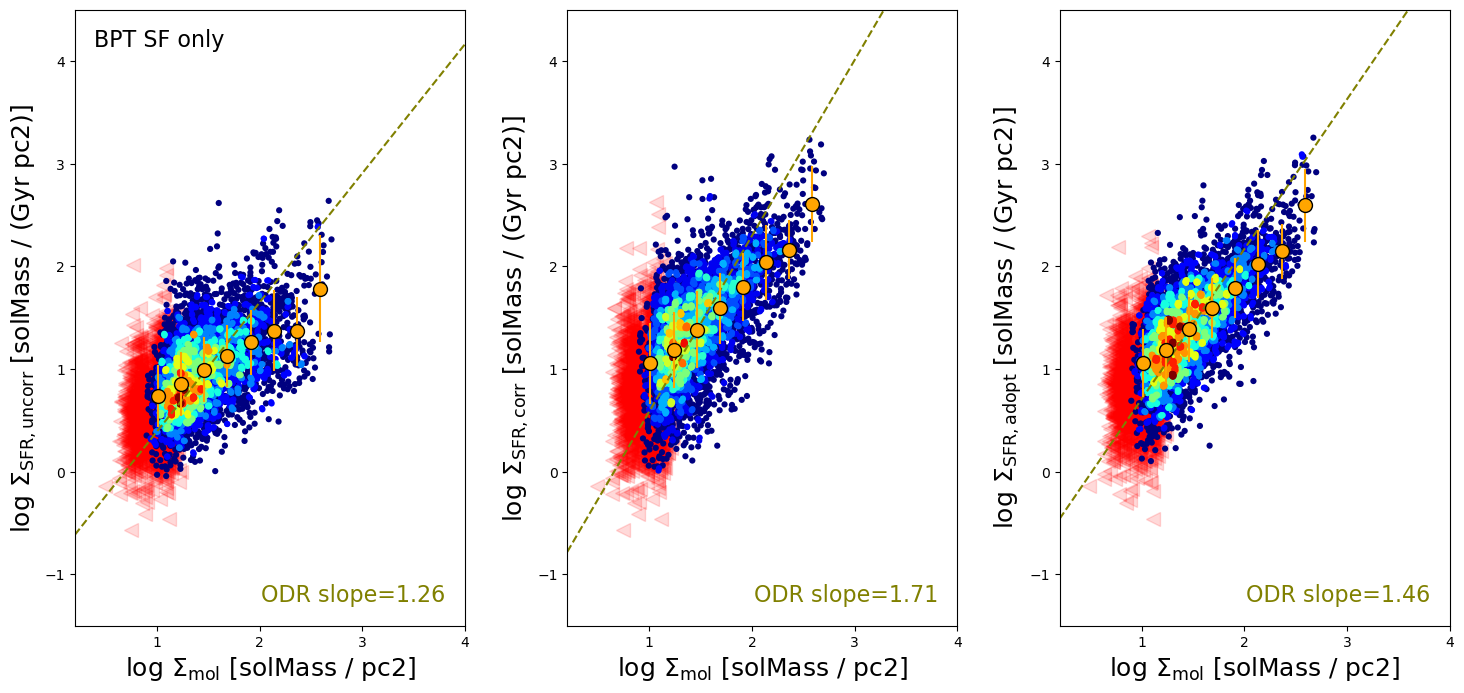

In [10]:
emom0max = False
for bptsel in [False, True]:
    fig, axarr = plt.subplots(1, 3, figsize=(18,8))
    ylbl = ['uncorr', 'corr', 'adopt']

    for i, sfrcol in enumerate(['sigsfr0','sigsfr_corr','sigsfr_adopt']):
        sfrname = 'flux_'+sfrcol+'_sm'
        axarr[i].set_xlim(0.2,4)
        axarr[i].set_ylim(-1.5,4.5)
        # Select data to plot (must be loggable)
        sf_det = hadet & ~np.isnan(fluxtab[sfrname]) & ~np.isnan(fluxtab['e_'+sfrname])
        if bptsel:
            xy_det =  codet &  sf_det & (fluxtab['SF_BPT_sm'] == 1)
            coulim = ~codet &  sf_det & (fluxtab['SF_BPT_sm'] == 1)
            sfulim =  codet & ~sf_det & (fluxtab['SF_BPT_sm'] == 1)
            notdet = ~codet & ~sf_det & (fluxtab['SF_BPT_sm'] == 1)
        else:
            xy_det =  codet &  sf_det
            coulim = ~codet &  sf_det
            sfulim =  codet & ~sf_det
            notdet = ~codet & ~sf_det
        print('\nNumber detected in both axes:',len(np.nonzero(xy_det)[0]))
        print('Not detected in sigmol:',len(np.nonzero(coulim)[0]))
        print('Not detected in', sfrcol+':', len(np.nonzero(sfulim)[0]))
        print('Not detected in either:',len(np.nonzero(notdet)[0]))

        # Plot the ODR fit
        x_dat = np.log10(fluxtab['sigmol'][xy_det])
        y_dat = np.log10(fluxtab[sfrname][xy_det])
        x_err = (fluxtab['e_sigmol'][xy_det]/fluxtab['sigmol'][xy_det])/np.log(10)
        y_err = (fluxtab['e_'+sfrname][xy_det]/fluxtab[sfrname][xy_det])/np.log(10)
        y0, e_y0, m, e_m, yscat = fitODR(x_dat, y_dat)
        xlims = axarr[i].get_xlim()
        xmod = np.linspace(xlims[0],xlims[1], 10)
        ymod = model([y0, m], xmod)
        axarr[i].plot(xmod, ymod, linestyle='--', color='olive', zorder=2)

        # Plot the detections colored by histogram
        x_det, y_det, z_det, *hist = xy2hist(x_dat, y_dat, log=False)
        sc = axarr[i].scatter(x_det, y_det, c=z_det, s=20, cmap='jet')
        x_bin, y_bin, y_binerr, ycnt = xy2binned(x_dat, y_dat, log=False, bins=8)
        axarr[i].errorbar(x_bin, y_bin, yerr=y_binerr, color='None', marker='o', mec='k',
                          ecolor='orange', mfc='orange', ms=10, ls=':', label='all')
        if emom0max:
            codetlim = msd_co(3*fluxtab['e_mom0max_12'])
        else:
            codetlim = 3*fluxtab['e_sigmol']
        axarr[i].plot(np.log10(codetlim[coulim]), 
                      np.log10(fluxtab[sfrname][coulim]), 
                      marker='<', alpha=0.15, color='r', ls='none', markersize=10,
                      zorder=-4, label=f'H$_2$ uplims ({np.sum(coulim)})')
        axarr[i].plot(np.log10(fluxtab['sigmol'][sfulim]), 
                      np.log10(3*fluxtab['e_'+sfrname][sfulim]), 
                      marker='v', alpha=0.3, color='lime', ls='none', markersize=10,
                      zorder=4, label=f'SFR uplims ({np.sum(sfulim)})')
        axarr[i].text(0.95,0.05, f'ODR slope={m:.2f}', size=16, ha='right',
                      va='center', color='olive', transform=axarr[i].transAxes)
        axarr[i].set_xlabel(r'log $\Sigma_{\rm mol}$ ['+str(fluxtab['sigmol'].unit)
                            +']',fontsize=18)
        axarr[i].set_ylabel(r'log $\Sigma_{\rm SFR,'+ylbl[i]+'}$ ['+
                            str(fluxtab[sfrname].unit)+']',fontsize=18)
        if bptsel and i==0:
            axarr[i].text(0.05,0.95, 'BPT SF only', size=16, ha='left',
                      va='center', transform=axarr[i].transAxes)
        elif i==0:
            axarr[i].text(0.05,0.95, 'No BPT selection', size=16, ha='left',
                      va='center', transform=axarr[i].transAxes)
        axarr[i].set_aspect('equal')
        axarr[i].xaxis.set_major_locator(MultipleLocator(1))
        axarr[i].yaxis.set_major_locator(MultipleLocator(1))
    if bptsel:
        plt.savefig('ha_extinct_bptsel.pdf', bbox_inches='tight')
    else:
        plt.savefig('ha_extinct.pdf', bbox_inches='tight')

### SF Law separated by stellar mass [cf. Fig. 17(a) of Bolatto+17]

Points from high-mass galaxies: 4128
Points from low-mass galaxies: 2914


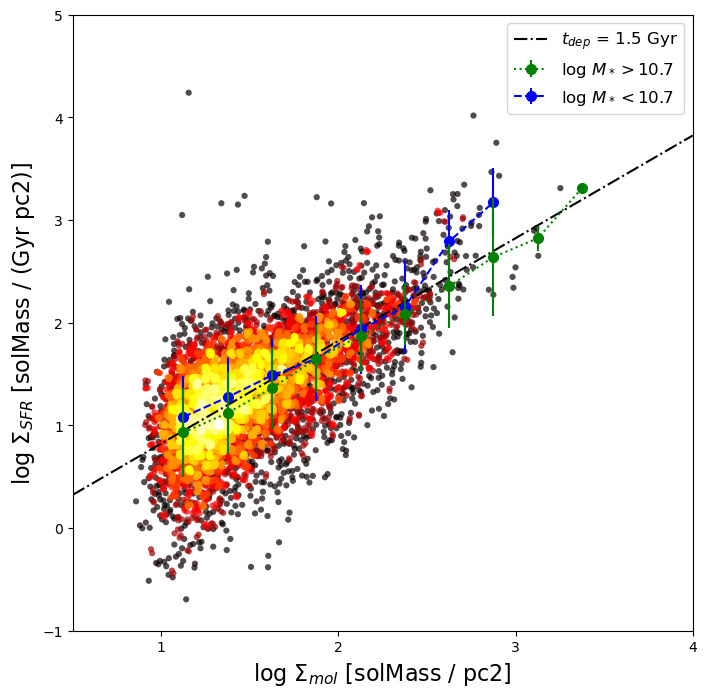

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
xlims=[0.5, 4]
x_det, y_det, z_det, *hist = xy2hist(fluxtab['sigmol'][twodet], 
                                     fluxtab['flux_sigsfr_adopt_sm'][twodet], log=True)
ax.scatter(x_det, y_det, c=z_det, s=20, cmap='hot', alpha=0.7)

himass = twodet & (fluxtab['caMstars'] > 10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = twodet & (fluxtab['caMstars'] <= 10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

xhi_bin, yhi_bin, yhi_err, yhi_cnt = xy2binned(fluxtab['sigmol'][himass], 
                                      fluxtab['flux_sigsfr_adopt_sm'][himass], bins=10, range=[1,3.5])
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
xlo_bin, ylo_bin, ylo_err, ylo_cnt = xy2binned(fluxtab['sigmol'][lomass], 
                                      fluxtab['flux_sigsfr_adopt_sm'][lomass], bins=10, range=[1,3.5])
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')

# 1.5 Gyr depletion time
xmod = np.linspace(xlims[0], xlims[1], num=10)
ymod = xmod - np.log10(1.5)
ax.plot(xmod, ymod, ls='-.', color='k', label='$t_{dep}$ = 1.5 Gyr')

ax.set_xlabel(r'log $\Sigma_{mol}$ ['+str(fluxtab['sigmol'].unit)+']',fontsize=16)
ax.set_ylabel(r'log $\Sigma_{SFR}$ ['+str(fluxtab['flux_sigsfr_adopt_sm'].unit)+']',fontsize=16)
ax.set_xlim(xlims)
ax.set_ylim(-1,5)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')

### SF Law separated by stellar surface density

High surface density points: 2215
Low surface density points: 4822


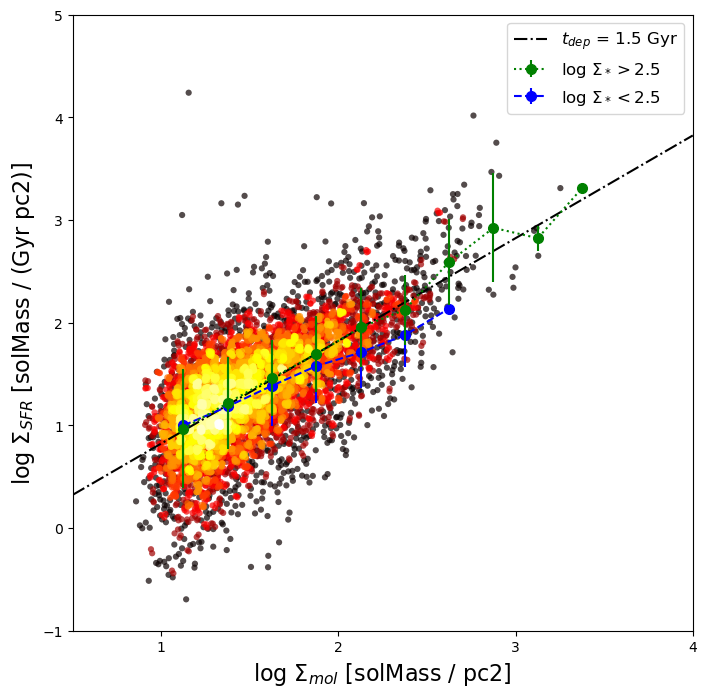

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
xlims=[0.5, 4]
x_det, y_det, z_det, *hist = xy2hist(fluxtab['sigmol'][twodet], 
                                     fluxtab['flux_sigsfr_adopt_sm'][twodet], log=True)
ax.scatter(x_det, y_det, c=z_det, s=20, cmap='hot', alpha=0.7)

himass = twodet & (fluxtab['sigstar_sm'] > 10**2.5)
print('High surface density points:',len(np.nonzero(himass)[0]))
lomass = twodet & (fluxtab['sigstar_sm'] <= 10**2.5)
print('Low surface density points:',len(np.nonzero(lomass)[0]))

xhi_bin, yhi_bin, yhi_err, yhi_cnt = xy2binned(fluxtab['sigmol'][himass], 
                                      fluxtab['flux_sigsfr_adopt_sm'][himass], bins=10, range=[1,3.5])
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $\Sigma_*>2.5$')
xlo_bin, ylo_bin, ylo_err, ylo_cnt = xy2binned(fluxtab['sigmol'][lomass], 
                                      fluxtab['flux_sigsfr_adopt_sm'][lomass], bins=10, range=[1,3.5])
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $\Sigma_*<2.5$')

# 1.5 Gyr depletion time
xmod = np.linspace(xlims[0], xlims[1], num=10)
ymod = xmod - np.log10(1.5)
ax.plot(xmod, ymod, ls='-.', color='k', label='$t_{dep}$ = 1.5 Gyr')

ax.set_xlabel(r'log $\Sigma_{mol}$ ['+str(fluxtab['sigmol'].unit)+']',fontsize=16)
ax.set_ylabel(r'log $\Sigma_{SFR}$ ['+str(fluxtab['flux_sigsfr_adopt_sm'].unit)+']',fontsize=16)
ax.set_xlim(xlims)
ax.set_ylim(-1,5)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')

### The three local relations plotted side by side (detections only, without and with BPT cut)
### Color coded by the third parameter, or by the offset from the SFMS

Plotting log $\Sigma_{\rm SFR}$ vs log $\Sigma_{\rm mol}$
Points from bin0: 1036
Points from bin1: 3707
Points from bin2: 1811
Points from bin3: 366
Plotting log $\Sigma_{\rm mol}$ vs log $\Sigma_{*}$
Points from bin0: 1450
Points from bin1: 2701
Points from bin2: 1903
Points from bin3: 495
Plotting log $\Sigma_{\rm SFR}$ vs log $\Sigma_{*}$
Points from bin0: 115
Points from bin1: 3924
Points from bin2: 2246
Points from bin3: 670
threeviews_carma.pdf


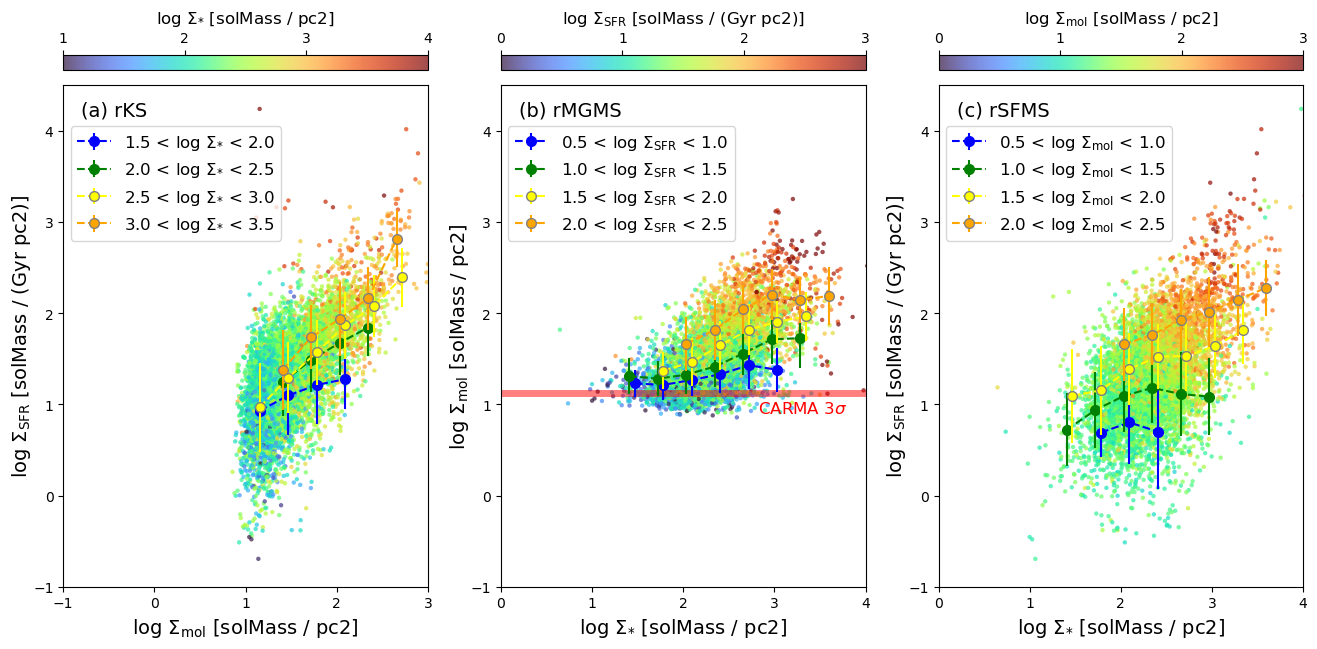

Plotting log $\Sigma_{\rm SFR}$ vs log $\Sigma_{\rm mol}$
Points from bin0: 747
Points from bin1: 2745
Points from bin2: 1011
Points from bin3: 109
Plotting log $\Sigma_{\rm mol}$ vs log $\Sigma_{*}$
Points from bin0: 726
Points from bin1: 1959
Points from bin2: 1502
Points from bin3: 354
Plotting log $\Sigma_{\rm SFR}$ vs log $\Sigma_{*}$
Points from bin0: 61
Points from bin1: 2715
Points from bin2: 1479
Points from bin3: 373
threeviews_carma_bptsel.pdf


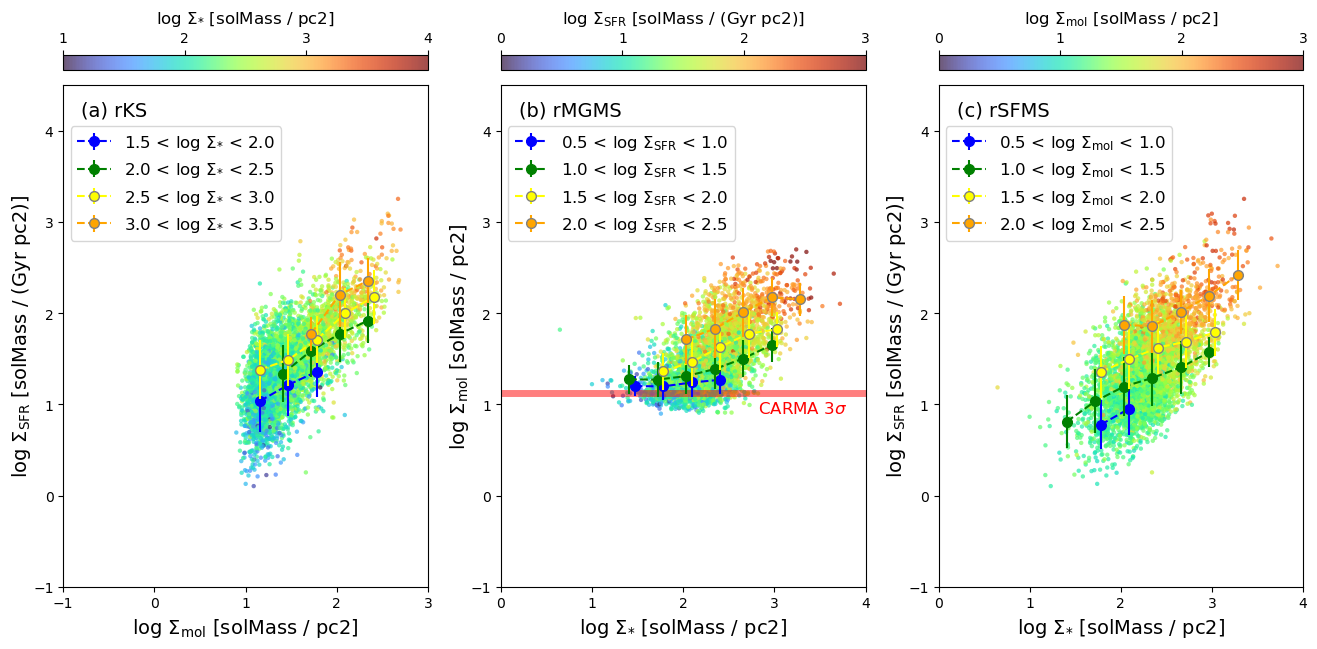

Plotting log $\Sigma_{\rm SFR}$ vs log $\Sigma_{\rm mol}$
Points from bin0: 744
Points from bin1: 1698
Points from bin2: 1669
Points from bin3: 1739
Plotting log $\Sigma_{\rm mol}$ vs log $\Sigma_{*}$
Points from bin0: 744
Points from bin1: 1698
Points from bin2: 1669
Points from bin3: 1739
Plotting log $\Sigma_{\rm SFR}$ vs log $\Sigma_{*}$
Points from bin0: 744
Points from bin1: 1698
Points from bin2: 1669
Points from bin3: 1739
threeviews_carma_delms.pdf


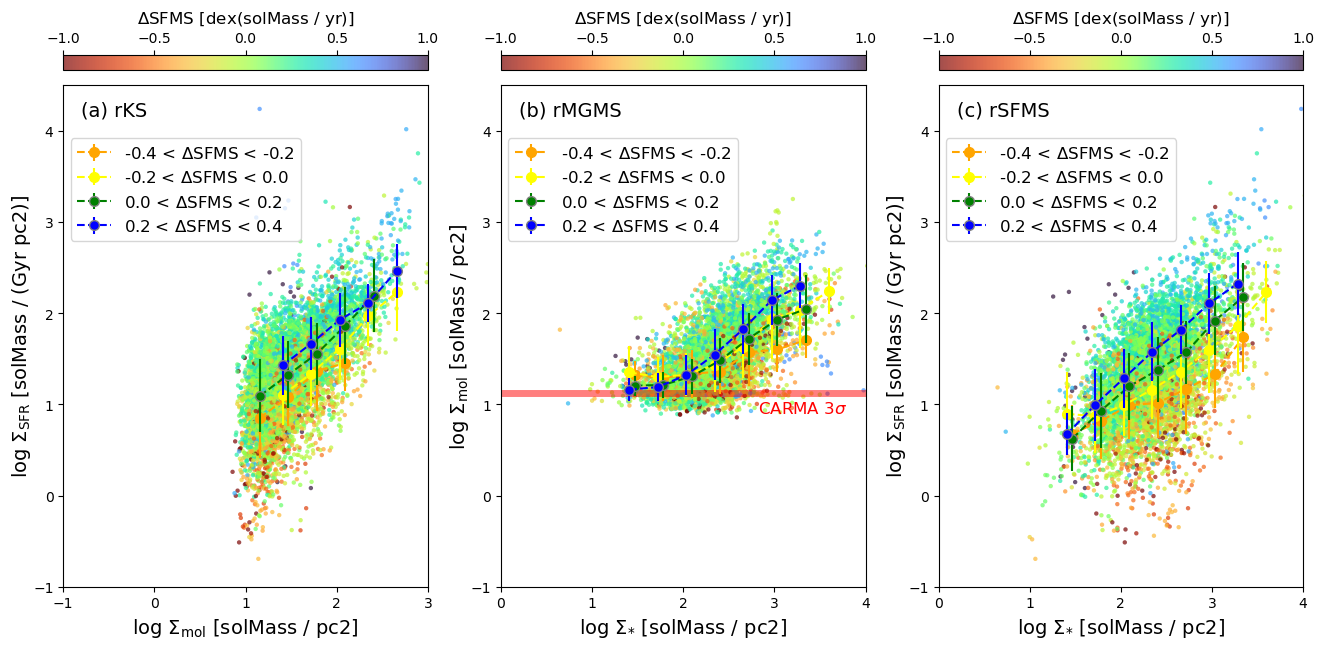

Plotting log $\Sigma_{\rm SFR}$ vs log $\Sigma_{\rm mol}$
Points from bin0: 385
Points from bin1: 1038
Points from bin2: 1214
Points from bin3: 1468
Plotting log $\Sigma_{\rm mol}$ vs log $\Sigma_{*}$
Points from bin0: 385
Points from bin1: 1038
Points from bin2: 1214
Points from bin3: 1468
Plotting log $\Sigma_{\rm SFR}$ vs log $\Sigma_{*}$
Points from bin0: 385
Points from bin1: 1038
Points from bin2: 1214
Points from bin3: 1468
threeviews_carma_delms_bptsel.pdf


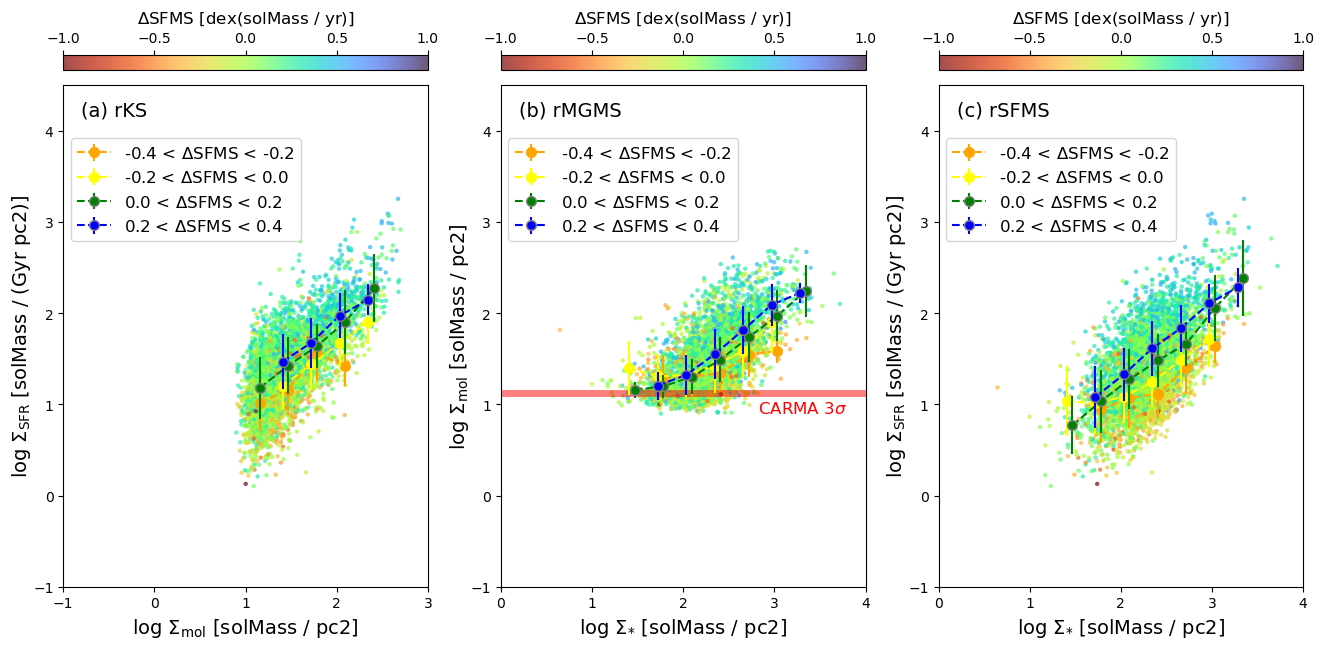

In [13]:
nmin = 10
for dodelms in [False, True]:
    for bptsel in [False, True]:

        if bptsel:
            threedet = codet & sfdet & (fluxtab['sigstar_sm'] > 0) & (fluxtab['SF_BPT_sm'] == 1)
        else:
            threedet = codet & sfdet & (fluxtab['sigstar_sm'] > 0)
        sig_mol  = np.log10(fluxtab['sigmol'][threedet])
        sig_star = np.log10(fluxtab['sigstar_sm'][threedet])
        sig_sfr  = np.log10(fluxtab['flux_sigsfr_adopt_sm'][threedet])
        del_ms   = fluxtab['delSFR'][threedet]

        fig, axs = plt.subplots(1, 3, figsize=(16,8), sharey=False)
        plt.subplots_adjust(wspace=0.2)

        xval = [sig_mol,  sig_star, sig_star]
        yval = [sig_sfr,  sig_mol,  sig_sfr]
        xlbl = [r'log $\Sigma_{\rm mol}$', r'log $\Sigma_{*}$', r'log $\Sigma_{*}$']
        ylbl = [r'log $\Sigma_{\rm SFR}$', r'log $\Sigma_{\rm mol}$', r'log $\Sigma_{\rm SFR}$']
        if not dodelms:
            zval = [sig_star, sig_sfr,  sig_mol]
            zlbl = [r'log $\Sigma_{*}$', r'log $\Sigma_{\rm SFR}$', r'log $\Sigma_{\rm mol}$']
        else:
            zval = [del_ms, del_ms,  del_ms]
            zlbl = [r'$\Delta$SFMS', r'$\Delta$SFMS', r'$\Delta$SFMS']

        if not dodelms:
            cmap = 'turbo'
            cols = ['blue', 'green', 'yellow', 'orange']
            lobin = [1.5, 0.5, 0.5]
            dbin = 0.5
            vmin  = [1.0, 0.0, 0.0]
            vmax  = [4.0, 3.0, 3.0]
        else:
            cmap = 'turbo_r'
            cols = ['orange', 'yellow', 'green', 'blue']
            lobin = [-0.4, -0.4, -0.4]
            dbin  = 0.2
            vmin  = [-1, -1, -1]
            vmax  = [ 1,  1,  1]

        for i in range(len(xval)):
            sc = axs[i].scatter(xval[i], yval[i], c=zval[i], s=10, cmap=cmap, 
                                alpha=0.7, vmin=vmin[i], vmax=vmax[i])
            print('Plotting {} vs {}'.format(ylbl[i],xlbl[i]))
            bin0 = (zval[i] > lobin[i]) & (zval[i] < lobin[i]+1*dbin)
            label0 = '{:.1f} < {} < {:.1f}'.format(lobin[i],zlbl[i],lobin[i]+1*dbin)
            print('Points from bin0:',len(np.nonzero(bin0)[0]))
            bin1 = (zval[i] > lobin[i]+1*dbin) & (zval[i] < lobin[i]+2*dbin)
            label1 = '{:.1f} < {} < {:.1f}'.format(lobin[i]+1*dbin,zlbl[i],lobin[i]+2*dbin)
            print('Points from bin1:',len(np.nonzero(bin1)[0]))
            bin2 = (zval[i] > lobin[i]+2*dbin) & (zval[i] < lobin[i]+3*dbin)
            label2 = '{:.1f} < {} < {:.1f}'.format(lobin[i]+2*dbin,zlbl[i],lobin[i]+3*dbin)
            print('Points from bin2:',len(np.nonzero(bin2)[0]))
            bin3 = (zval[i] > lobin[i]+3*dbin) & (zval[i] < lobin[i]+4*dbin)
            label3 = '{:.1f} < {} < {:.1f}'.format(lobin[i]+3*dbin,zlbl[i],lobin[i]+4*dbin)
            print('Points from bin3:',len(np.nonzero(bin3)[0]))

            if i == 0:
                axs[i].text(0.05,0.95,'(a) rKS',size=14,ha='left',va='center',transform=axs[i].transAxes)
            if i == 1:
                axs[i].text(0.05,0.95,'(b) rMGMS',size=14,ha='left',va='center',transform=axs[i].transAxes)
                axs[i].axhline(1.12, ls='-', color='r', lw=5, alpha=0.5)
                axs[i].text(3.8,0.9,'CARMA 3$\sigma$',ha='right',color='r', size=12)
            elif i == 2:
                axs[i].text(0.05,0.95,'(c) rSFMS',size=14,ha='left',va='center',transform=axs[i].transAxes)
        
            xbin0, ybin0, ybin0_err, ycnt0 = xy2binned(xval[i][bin0], yval[i][bin0], bins=8,
                                                       log=False, range=[1,3.5])
            axs[i].errorbar(xbin0[ycnt0>=nmin], ybin0[ycnt0>=nmin], yerr=ybin0_err[ycnt0>=nmin], 
                            zorder=3, color=cols[0], marker='o', ms=7, ls='--', label=label0)
            xbin1, ybin1, ybin1_err, ycnt1 = xy2binned(xval[i][bin1], yval[i][bin1], bins=8, 
                                                log=False, range=[1.25,3.75])
            axs[i].errorbar(xbin1[ycnt1>=nmin], ybin1[ycnt1>=nmin], yerr=ybin1_err[ycnt1>=nmin], 
                            zorder=4, color=cols[1], marker='o', ms=7, ls='--', label=label1)
            xbin2, ybin2, ybin2_err, ycnt2 = xy2binned(xval[i][bin2], yval[i][bin2], bins=8,
                                                       log=False, range=[1,3.5])
            axs[i].errorbar(xbin2[ycnt2>=nmin], ybin2[ycnt2>=nmin], yerr=ybin2_err[ycnt2>=nmin], 
                            zorder=5, color=cols[2], mec='grey', marker='o', ms=7, ls='--', label=label2)
            xbin3, ybin3, ybin3_err, ycnt3 = xy2binned(xval[i][bin3], yval[i][bin3], bins=8,
                                                       log=False, range=[1.25,3.75])
            axs[i].errorbar(xbin3[ycnt3>=nmin], ybin3[ycnt3>=nmin], yerr=ybin3_err[ycnt3>=nmin], 
                            zorder=6, color=cols[3], mec='grey', marker='o', ms=7, ls='--', label=label3)
            axs[i].set_xlabel(xlbl[i]+' ['+str(xval[i].unit)+']',fontsize=14)
            axs[i].set_ylabel(ylbl[i]+' ['+str(yval[i].unit)+']',fontsize=14,labelpad=0)

            axs[i].legend(fontsize='large', loc=(0.02,0.69))
            if i == 0:
                axs[i].set_xlim(-1, 3)
            else:
                axs[i].set_xlim(0, 4)
            axs[i].set_ylim(-1, 4.5)
            axs[i].set_aspect('equal')
            axs[i].xaxis.set_major_locator(MultipleLocator(1))
            axs[i].yaxis.set_major_locator(MultipleLocator(1))
            divider = make_axes_locatable(axs[i])
            cax = divider.append_axes('top', size='3%', pad=0.15)
            cbar = fig.colorbar(sc, cax=cax, orientation='horizontal')
            if not dodelms:
                cbar.ax.locator_params(nbins=3)
            else:
                cbar.ax.locator_params(nbins=4)
            cbar.set_label(zlbl[i]+' ['+str(zval[i].unit)+']', size=12, labelpad=6)
            cax.xaxis.set_label_position('top')
            cax.xaxis.set_ticks_position('top')
        outfile = 'threeviews_carma.pdf'
        if bptsel:
            outfile = outfile.replace('.pdf','_bptsel.pdf')
        if dodelms:
            outfile = outfile.replace('_carma','_carma_delms')
        print(outfile)
        plt.savefig(outfile, bbox_inches='tight')
        plt.show()

## Further comparisons of the 3 surface density variables

Points from high-mass galaxies: 4125
Points from low-mass galaxies: 2912
Points from high-mass galaxies: 4125
Points from low-mass galaxies: 2912


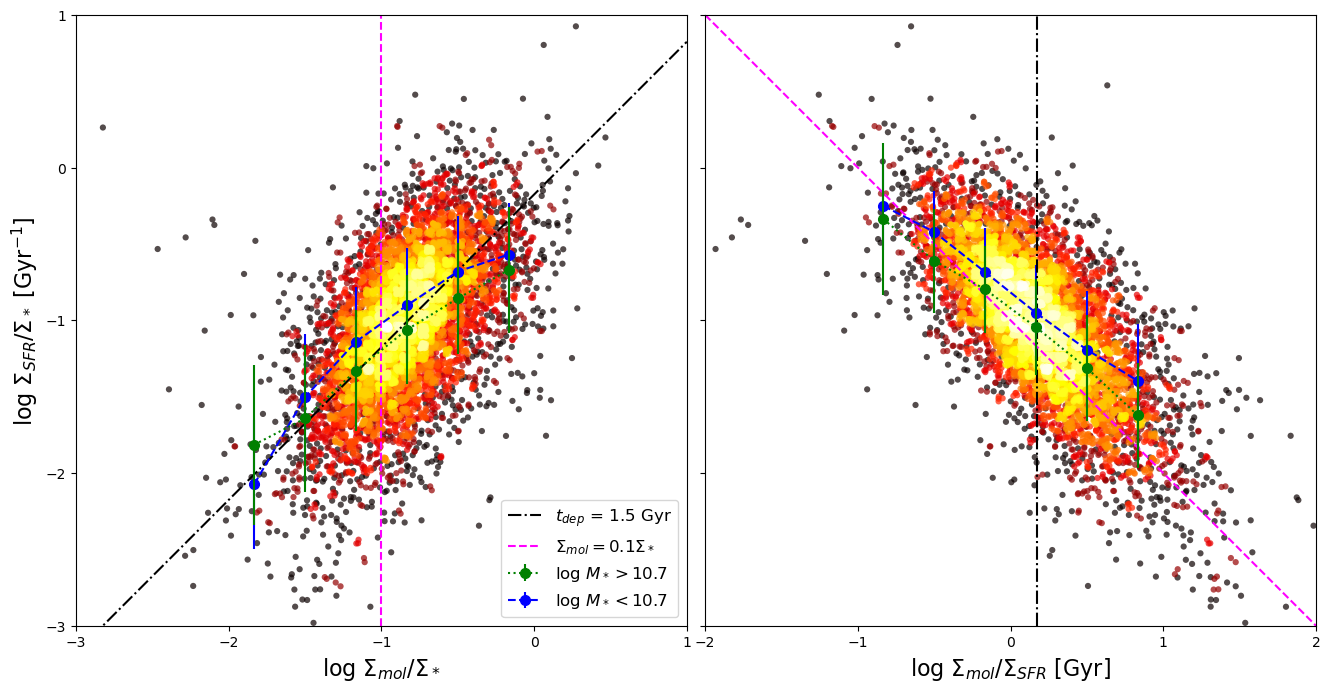

In [14]:
fig, axarr = plt.subplots(1, 2, figsize=(16,8), sharey=True)
plt.subplots_adjust(wspace=0.03)
xlbl = ['$\Sigma_{mol}$/$\Sigma_*$', '$\Sigma_{mol}$/$\Sigma_{SFR}$ [Gyr]']
xbinlim = [[-2,0], [-1,1]]
xlim = [[-3,1], [-2,2]]

for i, xcol in enumerate(['f_mol','t_dep']):
    valid = twodet & (fluxtab['ssfr'] > 0) & (fluxtab[xcol] > 0)
    x_det, y_det, z_det, *hist = xy2hist(fluxtab[xcol][valid], 
                                         fluxtab['ssfr'][valid], log=True)
    axarr[i].scatter(x_det, y_det, c=z_det, s=20, cmap='hot', alpha=0.7)

    himass = valid & (fluxtab['caMstars'] > 10.7)
    print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
    lomass = valid & (fluxtab['caMstars'] <= 10.7)
    print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

    xhi_bin, yhi_bin, yhi_err, yhi_cnt = xy2binned(fluxtab[xcol][himass], 
                                          fluxtab['ssfr'][himass], bins=6, range=xbinlim[i])
    axarr[i].errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
                color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
    xlo_bin, ylo_bin, ylo_err, ylo_cnt = xy2binned(fluxtab[xcol][lomass], 
                                          fluxtab['ssfr'][lomass], bins=6, range=xbinlim[i])
    axarr[i].errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
                color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')

    # Plot fiducial lines
    xmod = np.linspace(xlim[i][0], xlim[i][1], num=10)
    if i == 0:
        tdepmod = xmod - np.log10(1.5)
        axarr[i].plot(xmod, tdepmod, ls='-.', color='k', label='$t_{dep}$ = 1.5 Gyr')
        axarr[i].axvline(-1, ls='--', color='magenta', label='$\Sigma_{mol} = 0.1\Sigma_*$')
        axarr[i].legend(fontsize='large')
        axarr[i].set_ylabel(r'log $\Sigma_{SFR}$/$\Sigma_*$ [Gyr$^{-1}$]',fontsize=16)
    else:
        axarr[i].axvline(np.log10(1.5), ls='-.', color='k')
        fmolmod = -xmod - 1
        axarr[i].plot(xmod, fmolmod, ls='--', color='magenta')
    axarr[i].set_xlabel('log '+xlbl[i],fontsize=16)
    axarr[i].set_xlim(xlim[i])
    axarr[i].set_ylim(-3,1)
    axarr[i].set_aspect('equal')
    axarr[i].xaxis.set_major_locator(MultipleLocator(1))
    axarr[i].yaxis.set_major_locator(MultipleLocator(1))

Points from high-mass galaxies: 4125
Points from low-mass galaxies: 2912
Points from high-mass galaxies: 4125
Points from low-mass galaxies: 2912


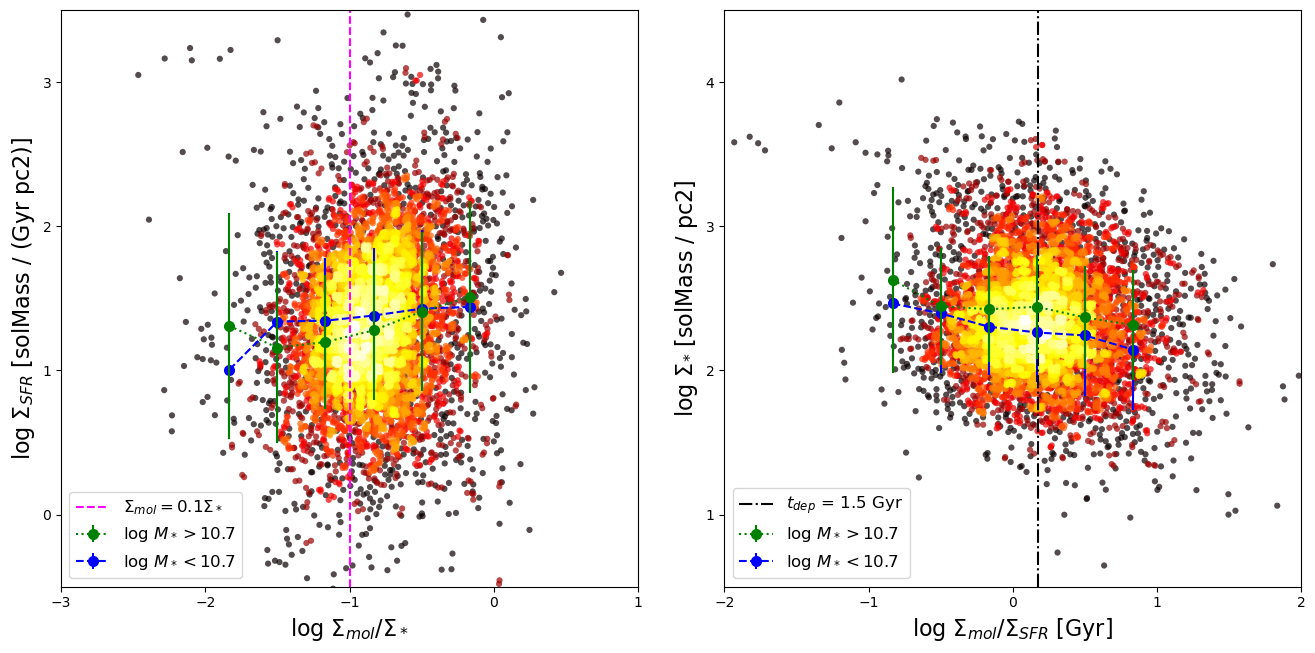

In [15]:
fig, axarr = plt.subplots(1, 2, figsize=(16,8))
plt.subplots_adjust(wspace=0.15)

xlbl = ['$\Sigma_{mol}$/$\Sigma_*$', '$\Sigma_{mol}$/$\Sigma_{SFR}$ [Gyr]']
xbinlim = [[-2,0], [-1,1]]
xlim = [[-3,1], [-2,2]]
ylim = [[-0.5,3.5], [0.5,4.5]]
xcols = ['f_mol', 't_dep']
ycols = ['flux_sigsfr_adopt_sm', 'sigstar_sm']

for i, xcol in enumerate(xcols):
    valid = twodet & (fluxtab[ycols[i]] > 0) & (fluxtab[xcol] > 0)
    x_det, y_det, z_det, *hist = xy2hist(fluxtab[xcol][valid], 
                                         fluxtab[ycols[i]][valid], log=True)
    axarr[i].scatter(x_det, y_det, c=z_det, s=20, cmap='hot', alpha=0.7)

    himass = valid & (fluxtab['caMstars'] > 10.7)
    print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
    lomass = valid & (fluxtab['caMstars'] <= 10.7)
    print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

    xhi_bin, yhi_bin, yhi_err, yhi_cnt = xy2binned(fluxtab[xcol][himass], 
                                          fluxtab[ycols[i]][himass], bins=6, range=xbinlim[i])
    axarr[i].errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
                color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
    xlo_bin, ylo_bin, ylo_err, ylo_cnt = xy2binned(fluxtab[xcol][lomass], 
                                          fluxtab[ycols[i]][lomass], bins=6, range=xbinlim[i])
    axarr[i].errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
                color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')

    # Plot fiducial lines
    if i == 0:
        axarr[i].axvline(-1, ls='--', color='magenta', label='$\Sigma_{mol} = 0.1\Sigma_*$')
        axarr[i].set_ylabel(r'log $\Sigma_{SFR}$'+' ['+str(fluxtab[ycols[i]].unit)+']',fontsize=16)
    else:
        axarr[i].axvline(np.log10(1.5), ls='-.', color='k', label='$t_{dep}$ = 1.5 Gyr')
        axarr[i].set_ylabel(r'log $\Sigma_{*}$'+' ['+str(fluxtab[ycols[i]].unit)+']',fontsize=16)
    axarr[i].legend(fontsize='large',loc=3)
    axarr[i].set_xlabel('log '+xlbl[i],fontsize=16)
    axarr[i].set_xlim(xlim[i])
    axarr[i].set_ylim(ylim[i])
    axarr[i].set_aspect('equal')
    axarr[i].xaxis.set_major_locator(MultipleLocator(1))
    axarr[i].yaxis.set_major_locator(MultipleLocator(1))

## Depletion time vs. local stellar density or sSFR

Number of valid, invalid values: 7037 224088
Points from high-mass galaxies: 4125
Points from low-mass galaxies: 2912
Number of valid, invalid values: 7037 224088
Points from high-mass galaxies: 4125
Points from low-mass galaxies: 2912


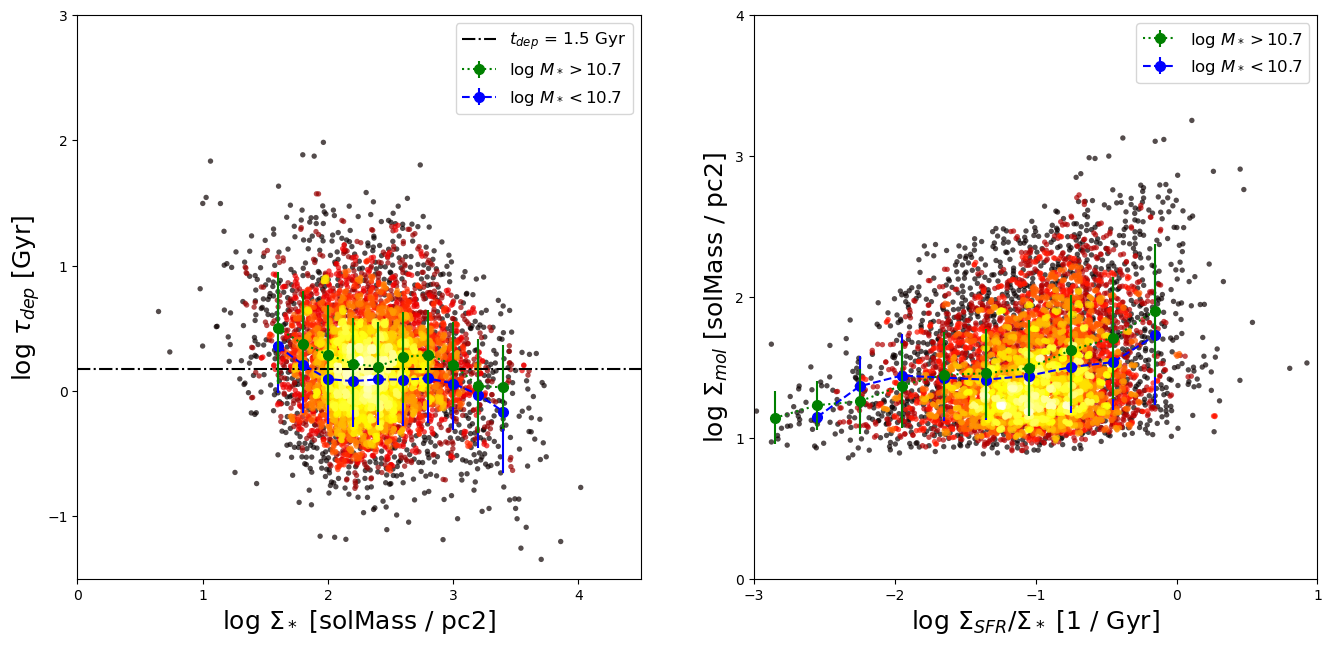

In [16]:
fig, axarr = plt.subplots(1, 2, figsize=(16,8))
xlbl = ['$\Sigma_*$', '$\Sigma_{SFR}$/$\Sigma_*$']
ycol = ['t_dep', 'sigmol']
xbinlim = [[1.5,3.5], [-3,0]]

for i, starcol in enumerate(['sigstar_sm','ssfr']):

    # Select data to plot (must be loggable)
    sstd_valid = twodet & (fluxtab[starcol]>0) & (fluxtab[ycol[i]]>0)
    print('Number of valid, invalid values:',len(np.nonzero(sstd_valid)[0]),len(np.nonzero(~sstd_valid)[0]))
    himass = sstd_valid & (fluxtab['caMstars'] > 10.7)
    print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
    lomass = sstd_valid & (fluxtab['caMstars'] <= 10.7)
    print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

    x_det, y_det, z_det, *hist = xy2hist(fluxtab[starcol][sstd_valid], 
                                         fluxtab[ycol[i]][sstd_valid], log=True)

    xhi_bin, yhi_bin, yhi_err, yhi_cnt = xy2binned(fluxtab[starcol][himass], 
                                          fluxtab[ycol[i]][himass], bins=10, range=xbinlim[i])
    xlo_bin, ylo_bin, ylo_err, ylo_cnt = xy2binned(fluxtab[starcol][lomass], 
                                          fluxtab[ycol[i]][lomass], bins=10, range=xbinlim[i])

    # Make the scatter plot
    axarr[i].scatter(x_det, y_det, c=z_det, s=15, cmap='hot', alpha=0.7)
    axarr[i].errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
                color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
    axarr[i].errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
                color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')
    axarr[i].set_xlabel(r'log '+xlbl[i]+' ['+str(fluxtab[starcol].unit)+']',fontsize=18)
    
    if i == 0:
        axarr[i].axhline(np.log10(1.5), ls='-.', color='k', label='$t_{dep}$ = 1.5 Gyr')
        axarr[i].set_xlim(0,4.5)
        axarr[i].set_ylabel(r'log $\tau_{dep}$ ['+str(fluxtab[ycol[i]].unit)+']',fontsize=18)
        axarr[i].set_ylim(-1.5,3)
    else:
        axarr[i].set_xlim(-3,1)
        axarr[i].set_ylabel(r'log $\Sigma_{mol}$ ['+str(fluxtab[ycol[i]].unit)+']',fontsize=18)
        axarr[i].set_ylim(0,4)
    axarr[i].set_aspect('equal')


    axarr[i].xaxis.set_major_locator(MultipleLocator(1))
    axarr[i].yaxis.set_major_locator(MultipleLocator(1))
    axarr[i].legend(fontsize='large')

## H$\alpha$ equivalent width vs. local sSFR

Number of valid, invalid values: 24277 206848
Points from high-mass galaxies: 12124
Points from low-mass galaxies: 12153


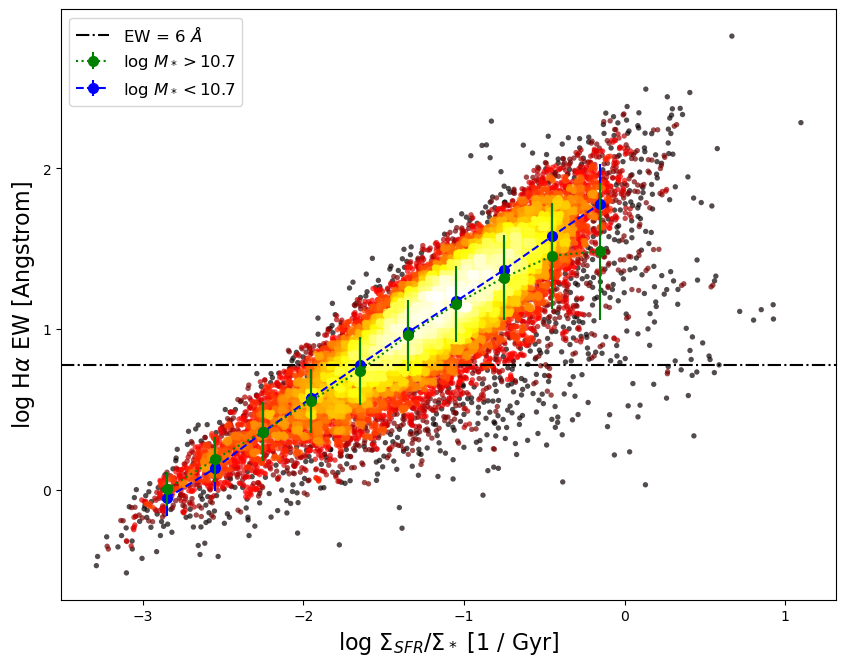

In [17]:
# Select data to plot (must be loggable)
ewvalid = sfdet & (fluxtab['ssfr']>0) & (abs(fluxtab['EW_Halpha_sm'])>0)
print('Number of valid, invalid values:',len(np.nonzero(ewvalid)[0]),len(np.nonzero(~ewvalid)[0]))
himass = ewvalid & (fluxtab['caMstars'] > 10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = ewvalid & (fluxtab['caMstars'] <= 10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

x_det, y_det, z_det, *hist = xy2hist(fluxtab['ssfr'][ewvalid], 
                                     abs(fluxtab['EW_Halpha_sm'][ewvalid]), log=True)

xhi_bin, yhi_bin, yhi_err, yhi_cnt = xy2binned(fluxtab['ssfr'][himass], 
                                      abs(fluxtab['EW_Halpha_sm'][himass]), bins=10, range=[-3,0])
xlo_bin, ylo_bin, ylo_err, ylo_cnt = xy2binned(fluxtab['ssfr'][lomass], 
                                      abs(fluxtab['EW_Halpha_sm'][lomass]), bins=10, range=[-3,0])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x_det, y_det, c=z_det, s=15, cmap='hot', alpha=0.7)
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')

ax.set_xlabel(r'log $\Sigma_{SFR}$/$\Sigma_*$ ['+str(fluxtab['ssfr'].unit)+']',fontsize=16)
ax.set_ylabel(r'log H$\alpha$ EW ['+str(fluxtab['EW_Halpha_sm'].unit)+']',fontsize=16)
ax.set_aspect('equal')
ax.axhline(np.log10(6), ls='-.', color='k', label='EW = 6 $\AA$')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.legend(fontsize='large')